In [8]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [9]:
import numpy as np
import matplotlib.lines as mlines

P = 19
A = -3
B = 5

# Following two functions for inverting number on field of integers modulo p are from
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
def extended_euclidean_algorithm(a, b):
    """
    Returns a three-tuple (gcd, x, y) such that
    a * x + b * y == gcd, where gcd is the greatest
    common divisor of a and b.

    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case.
    """
    s, old_s = 0, 1
    t, old_t = 1, 0
    r, old_r = b, a

    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t

    return old_r, old_s, old_t


def inverse_of(n, p):
    """
    Returns the multiplicative inverse of
    n modulo p.

    This function returns an integer m such that
    (n * m) % p == 1.
    """
    gcd, x, y = extended_euclidean_algorithm(n, p)
    assert (n * x + p * y) % p == gcd

    if gcd != 1:
        # Either n is 0, or p is not a prime number.
        raise ValueError(
            '{} has no multiplicative inverse '
            'modulo {}'.format(n, p))
    else:
        return x % p

    
class Point:
    def __init__(self, p, x=float('inf'), y=float('inf')):
        self.p = p
        self.x = x % p
        self.y = y % p
        
    def __repr__(self):
        return "Point(p={}, x={}, y={})".format(self.p, self.x, self.y)
    
    def __add__(self, other):
        assert type(other) is Point
        if self.x == other.x and self.y == other.y:
            return self.double()
        dx = other.x - self.x
        dy = other.y - self.y
        if dx == 0:
            return Point()
        slope = dy * inverse_of(dx, self.p)
        x = (slope ** 2) - self.x - other.x
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def double(self):
        slope = (3 * (self.x ** 2) + A) * inverse_of(2 * self.y, self.p)
        x = (slope ** 2) - (2 * self.x)
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def oppsite(self):
        return Point(self.p, self.x, -self.y)
    
    def np(self):
        return np.array([self.x, self.y])
    

In [10]:
import matplotlib.pyplot as plt

def enumerate_points(p):
    # TODO: this is silly way, maybe there's a better way
    for x in range(p):
        for y in range(p):
            if (y ** 2) % p == ((x ** 3) + A * x + B) % p:
                yield (x, y)

                
def plot_curve(p, a, b, ax):
    points = list(enumerate_points(p))
    points = np.array(points)
    # print(points)

    ax.scatter(points[:,0], points[:,1], zorder=5)
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.set_ylim(top=p)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlim(right=p)

In [63]:
import math

from matplotlib.ticker import MaxNLocator


def point_distance(p0, p1):
    return ((p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2) ** 0.5


def wrap_line_segments(p0, p1):
    """Get line segments of the line between p0 and p1 that gets cut by edges
    
    """
    p0x, p0y = p0
    p1x, p1y = p1
    
    dx = p1x - p0x
    dy = p1y - p0y
    slope = dy / dx
    
    # index of block where line touches axis
    x_axis_start_idx = math.ceil(p0y / P)
    x_axis_end_idx = math.floor(p1y / P)
    y_axis_start_idx = math.ceil(p0x / P)
    y_axis_end_idx = math.floor(p1x / P)
    
    # x value is increasing
    if dx >= 0:
        # The value we are using on the y axis edge for end and start
        y_edge = (P, 0)
        # The x values on y axis
        y_axis_stops = list(map(lambda x: x * P, range(y_axis_start_idx, y_axis_end_idx + 1)))
    # x value is decreasing
    else:
        # The value we are using on the y axis edge for end and start
        y_edge = (0, P)
        # The x values on y axis
        y_axis_stops = list(map(lambda x: x * P, range(y_axis_start_idx - 1, y_axis_end_idx, -1)))

    # y value is increasing
    if dy >= 0:
        # The value we are using on the x axis edge for end and start
        x_edge = (P, 0)
        # The x values on y axis
        x_axis_stops = list(map(lambda y: y * P, range(x_axis_start_idx, x_axis_end_idx + 1)))
    # y value is decreasing
    else:
        # The value we are using on the x axis edge for end and start
        x_edge = (0, P)
        # The x values on y axis
        x_axis_stops = list(map(lambda y: y * P, range(x_axis_start_idx - 1, x_axis_end_idx, -1)))
    
    print("!! x stops", x_axis_stops)
    print("!! y stops", y_axis_stops)
    
    # The points on x axis
    x_axis_stop_points = list(map(lambda y: (p0x + (y - p0y) / slope, y), x_axis_stops))
    # The points on y axis
    y_axis_stop_points = list(map(lambda x: (x, p0y + (x - p0x) * slope), y_axis_stops))
    
    print("!! x x_stop_points", x_axis_stop_points)
    print("!! y y_stop_points", y_axis_stop_points)
    

    
    last_point = p0
    
    while len(x_axis_stop_points) or len(y_axis_stop_points):
        x_axis_stop_point = None
        y_axis_stop_point = None
        if x_axis_stop_points: 
            x_axis_stop_point = x_axis_stop_points[0]
        if y_axis_stop_points:
            y_axis_stop_point = y_axis_stop_points[0]
        
        if x_axis_stop_point == y_axis_stop_point:
            pass

        if x_axis_stop_point is not None and y_axis_stop_point is not None:
            # Distance from point on x axis to starting point
            x_axis_distance = point_distance(x_axis_stop_point, p0)
            # Distance from point on y axis to starting point
            y_axis_distance = point_distance(y_axis_stop_point, p0)
        # No more points on x axis, just pick y axis point
        elif x_axis_stop_point is None:
            x_axis_distance = 1
            y_axis_distance = 0
        # No more points on y axis, just pick x axis point
        elif y_axis_stop_point is None:
            x_axis_distance = 0
            y_axis_distance = 1
        
        if x_axis_distance < y_axis_distance:
            print("@@@ pick x axis point", x_axis_stop_point)
            x_axis_stop_points.pop(0)
            yield (last_point, (x_axis_stop_point[0] % P, x_edge[0]))
            last_point = (x_axis_stop_point[0] % P, x_edge[1])
        else:
            print("@@@ pick y axis point", y_axis_stop_point)
            y_axis_stop_points.pop(0)
            yield (last_point, (y_edge[0], y_axis_stop_point[1] % P))
            last_point = (y_edge[1], y_axis_stop_point[1] % P)
    
    yield (last_point, (p1[0] % P, p1[1] % P))

    
def plot_distinct_point_curve(p0, p1, p0_annotation, p1_annotation, third_point_annotation, sum_point_annotation):
    p2 = p0 + p1

    fig, ax = plt.subplots()

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plot_curve(P, A, B, ax)

    dx = p1.x - p0.x
    dy = p1.y - p0.y
    
    dx_dy_gcd = math.gcd(dx, dy)
    dx = int(dx / dx_dy_gcd)
    dy = int(dy / dx_dy_gcd)
    
    cx = p0.x
    cy = p0.y
    
    p2_flip = -p2.y % P
    
    while (cx % P) != p2.x or (cy % P) != p2_flip:
        cx += dx
        cy += dy
    
    print("$$", cx, cy)
    line_points = list(wrap_line_segments((p0.x, p0.y), (cx, cy)))
    
    for line_point0, line_point1 in line_points:
        print(line_point0, line_point1)
        ax.add_line(mlines.Line2D(
            [line_point0[0], line_point1[0]],
            [line_point0[1], line_point1[1]],
            color='r',
            zorder=1,
        ))
        
#         newx = cx
#         newy = cy
#         newx += dx
#         newy += dy
#         ax.add_line(mlines.Line2D([cx, newx], [cy, newy], color='r', zorder=1))
#         newx %= P
#         newy %= P
#         # If the line cross edge, let's draw the second part from the pointer after warping
#         if newx < cx or newy < cy:
#             ax.add_line(mlines.Line2D([newx - dx, newx], [newy - dy, newy], color='r', zorder=1))
#         cx = newx
#         cy = newy

    print()

    ax.annotate(p0_annotation, xy=p0.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(p1_annotation, xy=p1.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(sum_point_annotation, xy=p2.np(), xytext=(-5, 5), textcoords='offset points')
    
    plt.show()

$$ 18 122
!! x stops [19, 38, 57, 76, 95, 114]
!! y stops []
!! x x_stop_points [(5.125, 19), (7.5, 38), (9.875, 57), (12.25, 76), (14.625, 95), (17.0, 114)]
!! y y_stop_points []
@@@ pick x axis point (5.125, 19)
@@@ pick x axis point (7.5, 38)
@@@ pick x axis point (9.875, 57)
@@@ pick x axis point (12.25, 76)
@@@ pick x axis point (14.625, 95)
@@@ pick x axis point (17.0, 114)
(3, 2) (5.125, 19)
(5.125, 0) (7.5, 19)
(7.5, 0) (9.875, 19)
(9.875, 0) (12.25, 19)
(12.25, 0) (14.625, 19)
(14.625, 0) (17.0, 19)
(17.0, 0) (18, 8)



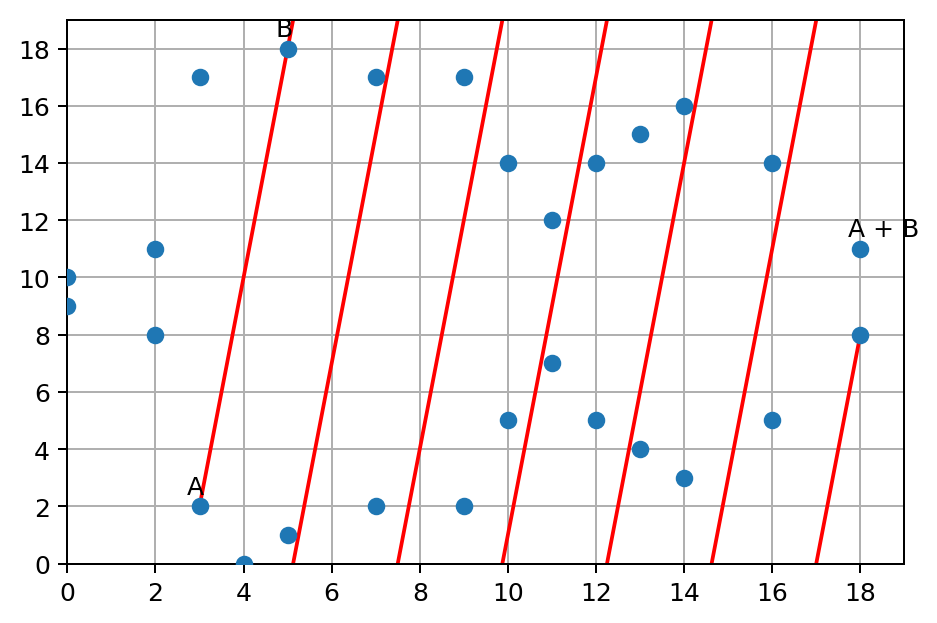

Point(p=19, x=18, y=11)

In [64]:
a = Point(P, 3, 2)
b = Point(P, 5, 18)
c = Point(P, 10, 14)
plot_distinct_point_curve(
    a, b,
    'A', 'B', '', 'A + B'
)
a + b

$$ 10 5
!! x stops []
!! y stops []
!! x x_stop_points []
!! y y_stop_points []
(5, 18) (10, 5)



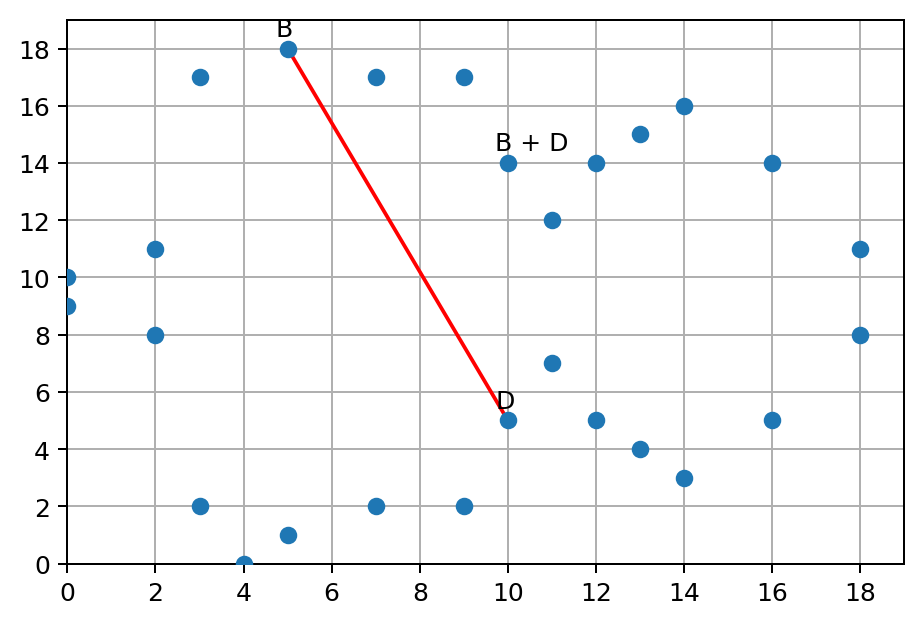

Point(p=19, x=10, y=14)

In [76]:
d = Point(p=19, x=10, y=5)
plot_distinct_point_curve(
    b, d,
    'B', 'D', '', 'B + D'
)
b + d

In [77]:
(a + b) + c, a + (b + c)

(Point(p=19, x=14, y=16), Point(p=19, x=14, y=16))

In [52]:
list(range(1, -5, -1))

[1, 0, -1, -2, -3, -4]

In [56]:
70 % 19

13